In [1]:
from keras.layers import Input,Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from keras.callbacks.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
vgg = VGG16(input_shape=[48,48] + [3], weights='imagenet', include_top=False)

In [3]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

In [4]:
for layer in vgg.layers:
    layer.trainable = False

In [5]:
flat = Flatten()(vgg.output)
layer1 = Dense(units=128,activation='relu')(flat)
output = Dense(units=7,activation='softmax')(layer1)
model = Model(inputs=vgg.input,outputs=output)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0   

In [6]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                     horizontal_flip=True,
                                     shear_range = 0.2,
                                     zoom_range = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/255)

training_dataset = train_datagen.flow_from_directory('datasets/train',
                                                 target_size = (48, 48),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')
test_dataset = test_datagen.flow_from_directory('datasets/train',
                                                 target_size = (48, 48),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 28709 images belonging to 7 classes.
Found 28709 images belonging to 7 classes.


In [7]:
checkpoint = ModelCheckpoint('model1.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='min') 

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [8]:
final = model.fit_generator(training_dataset,
                              validation_data=test_dataset,
                              callbacks=[checkpoint],
                              epochs=20,
                              steps_per_epoch=len(training_dataset),
                              validation_steps=len(test_dataset))

Epoch 1/20
898/898 [==============================] - 30s 34ms/step - loss: 1.6623 - accuracy: 0.3429 - val_loss: 1.9345 - val_accuracy: 0.3844

Epoch 00001: val_loss improved from inf to 1.93446, saving model to model1.h5
Epoch 2/20
898/898 [==============================] - 29s 32ms/step - loss: 1.5950 - accuracy: 0.3762 - val_loss: 1.4519 - val_accuracy: 0.3972

Epoch 00002: val_loss improved from 1.93446 to 1.45186, saving model to model1.h5
Epoch 3/20
898/898 [==============================] - 28s 32ms/step - loss: 1.5711 - accuracy: 0.3865 - val_loss: 1.7782 - val_accuracy: 0.4216

Epoch 00003: val_loss did not improve from 1.45186
Epoch 4/20
898/898 [==============================] - 29s 32ms/step - loss: 1.5523 - accuracy: 0.3934 - val_loss: 0.9780 - val_accuracy: 0.4152

Epoch 00004: val_loss improved from 1.45186 to 0.97796, saving model to model1.h5
Epoch 5/20
898/898 [==============================] - 29s 32ms/step - loss: 1.5380 - accuracy: 0.4020 - val_loss: 1.4977 - val_

In [10]:
from numba import cuda
cuda.select_device(0)
cuda.close()

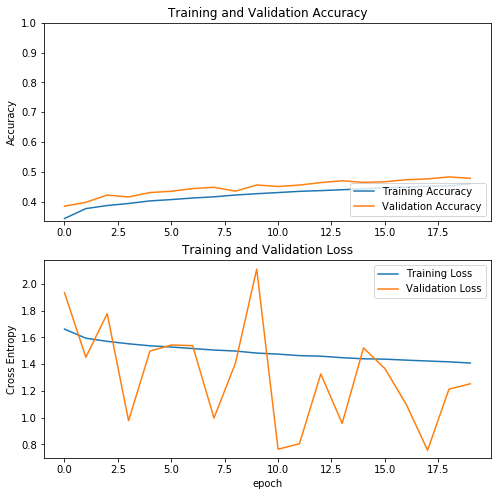

In [14]:
acc = final.history['accuracy']
val_acc = final.history['val_accuracy']

loss = final.history['loss']
val_loss = final.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim(0.7)
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()